In [1]:
from imports import *

# Fetch dataset

In [2]:
df = pd.read_csv('kddcup.data', delimiter=',')
df.columns = sa_columns + ["target"]
print(f"{df.columns}")
print(np.array(df.head(1)))

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'target'],
      dtype='object')
[[0 'tcp' 'http' 'SF' 162 4528 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 2 2 0.0
  0.0 0.0 0.0 1.0 0.0 0.0 1 1 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 'normal.']]


# Configuration 1

In [6]:
target_anomaly_rate = 0.1

df = pd.read_csv('kddcup.data', delimiter=',')
df.columns = sa_columns + ["target"]
dfsf = df[df["logged_in"]== 1]
print(len(dfsf)- len(dfsf.loc[dfsf["target"]=='normal.']))
dfsf = dfsf[sf_columns + ["target"]] 
# print(dfsf.head(1))

anomaly_rate = 1.0 - len(dfsf.loc[dfsf["target"]=='normal.'])/len(dfsf)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(dfsf)} records")

dfsf['binary_target'] = [1 if x=='normal.' else -1 for x in dfsf["target"]]
toDecode = toDecodeSF
leSF = preprocessing.LabelEncoder()
for f in toDecode:
    dfsf[f] = leSF.fit_transform(dfsf[f])

x_train, x_test, y_train, y_test = train_test_split(dfsf.drop(["target", 'binary_target'], axis=1), dfsf['binary_target'], test_size=0.25, random_state=1)

3377
anomaly rate is 0.5% out of 703066 records


Just like with sklearn SA dataset, we selected all of the 'normal' data with a small portion of outliers to reach our target anomaly rate

# Cross-validation for Isolation Forest

In [3]:
def cross_validation(contamination):
    highest_score = 0
    highest_score_c = 0
    for c in contamination:
        s = datetime.datetime.now()
        y_pred = IsolationForest(random_state=1, n_jobs=-1, max_samples=0.25, n_estimators=100, contamination=c).fit(x_train).predict(x_test)
        t = datetime.datetime.now() - s
        p, r, f, s = map(lambda x: x[0], precision_recall_fscore_support(y_test, y_pred, labels=[-1]))
        # p = tp / (tp + fp)
        a = roc_auc_score(y_test, y_pred)
        if p + r + a > highest_score: highest_score = p + r + a; highest_score_c = c
        
        yp = np.array(y_pred)
        yt = np.array(y_test)
        
        prediction = yp[np.where(yt == -1)]

        tp = len(yp[np.where(prediction == -1)])
        print(tp)
        fp = tp / p - tp
        
        # predicted true
        positives = yp[np.where(yp == -1)]
        print(f"{len(positives)} ({tp}) -> fp = {len(positives) - tp}/{fp}")
        print(f"AUC : {a:.1%} \t precision: {p:.3} \t recall: {r:.3} \t f1: {f}")
        print("--------------------")
    return highest_score_c

In [4]:
print(set(np.array(y_test)))

{1, -1}


In [5]:
contamination = [0.01]
c_max = cross_validation(contamination)
c_max

1354
contamination: 0.01 	 tp: 1354/32011 -> fp = 30657
AUC : 51.8% 	 precision: 0.386 	 recall: 0.0423 	 f1: 0.07623659243827595
--------------------


0.01

In [6]:
contamination = [round(0.01 + 0.01*i, 2) for i in range(10)]
c_max = cross_validation(contamination)
c_max

1354
contamination: 0.01 	 tp: 1354/32011 -> fp = 30657
AUC : 51.8% 	 precision: 0.386 	 recall: 0.0423 	 f1: 0.07623659243827595
--------------------
2793
contamination: 0.02 	 tp: 2793/32011 -> fp = 29218
AUC : 53.7% 	 precision: 0.398 	 recall: 0.0873 	 f1: 0.1430950124241105
--------------------
4025
contamination: 0.03 	 tp: 4025/32011 -> fp = 27986
AUC : 55.2% 	 precision: 0.376 	 recall: 0.126 	 f1: 0.1883922302831734
--------------------
5422
contamination: 0.04 	 tp: 5422/32011 -> fp = 26589
AUC : 57.1% 	 precision: 0.382 	 recall: 0.169 	 f1: 0.2346018216039634
--------------------
6541
contamination: 0.05 	 tp: 6541/32011 -> fp = 25470
AUC : 58.5% 	 precision: 0.371 	 recall: 0.204 	 f1: 0.2634472481221177
--------------------
7947
contamination: 0.06 	 tp: 7947/32011 -> fp = 24064
AUC : 60.4% 	 precision: 0.376 	 recall: 0.248 	 f1: 0.29916991360325257
--------------------
9159
contamination: 0.07 	 tp: 9159/32011 -> fp = 22852
AUC : 61.9% 	 precision: 0.373 	 recall: 0.286

0.08

In [7]:
contamination = [round(0.1*i, 1) for i in range(1, 7)]
c_max_2 = cross_validation(contamination)
c_max_2

10834
contamination: 0.1 	 tp: 10834/32011 -> fp = 21177
AUC : 63.1% 	 precision: 0.309 	 recall: 0.338 	 f1: 0.32285846259294027
--------------------
16243
contamination: 0.2 	 tp: 16243/32011 -> fp = 15768
AUC : 66.9% 	 precision: 0.229 	 recall: 0.507 	 f1: 0.31589490266243997
--------------------
32009
contamination: 0.3 	 tp: 32009/32011 -> fp = 2
AUC : 88.4% 	 precision: 0.301 	 recall: 1.0 	 f1: 0.4625243840762951
--------------------
32011
contamination: 0.4 	 tp: 32011/32011 -> fp = 0
AUC : 82.9% 	 precision: 0.226 	 recall: 1.0 	 f1: 0.36876483192406057
--------------------
32011
contamination: 0.5 	 tp: 32011/32011 -> fp = 0
AUC : 77.5% 	 precision: 0.181 	 recall: 1.0 	 f1: 0.3070010549534861
--------------------
32011
contamination: 0.6 	 tp: 32011/32011 -> fp = 0
AUC : 71.9% 	 precision: 0.151 	 recall: 1.0 	 f1: 0.26187009162303665
--------------------


0.3

In [8]:
c_max = c_max_2 if c_max_2 > c_max else c_max

In [9]:
contamination = [round(c_max - 0.1 + 0.01*i, 2) for i in range(11)]
c_max = cross_validation(contamination)
c_max

16243
contamination: 0.2 	 tp: 16243/32011 -> fp = 15768
AUC : 66.9% 	 precision: 0.229 	 recall: 0.507 	 f1: 0.31589490266243997
--------------------
16245
contamination: 0.21 	 tp: 16245/32011 -> fp = 15766
AUC : 66.6% 	 precision: 0.223 	 recall: 0.507 	 f1: 0.31022629619020337
--------------------
16245
contamination: 0.22 	 tp: 16245/32011 -> fp = 15766
AUC : 66.6% 	 precision: 0.223 	 recall: 0.507 	 f1: 0.31022629619020337
--------------------
16245
contamination: 0.23 	 tp: 16245/32011 -> fp = 15766
AUC : 66.6% 	 precision: 0.223 	 recall: 0.507 	 f1: 0.31022629619020337
--------------------
16245
contamination: 0.24 	 tp: 16245/32011 -> fp = 15766
AUC : 66.6% 	 precision: 0.223 	 recall: 0.507 	 f1: 0.31022629619020337
--------------------
32006
contamination: 0.25 	 tp: 32006/32011 -> fp = 5
AUC : 91.2% 	 precision: 0.361 	 recall: 1.0 	 f1: 0.5310039900787232
--------------------
32006
contamination: 0.26 	 tp: 32006/32011 -> fp = 5
AUC : 90.6% 	 precision: 0.347 	 recall: 1

0.25

AUC: 91.2%
              precision    recall  f1-score   support

          -1       0.36      1.00      0.53     32011
           1       1.00      0.82      0.90    321109

    accuracy                           0.84    353120
   macro avg       0.68      0.91      0.72    353120
weighted avg       0.94      0.84      0.87    353120



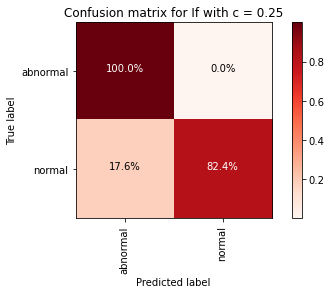

In [10]:
s = datetime.datetime.now()
y_pred = IsolationForest(random_state=1, n_jobs=-1, max_samples=0.25, n_estimators=100, contamination=c_max).fit(x_train).predict(x_test)
t = datetime.datetime.now()
cm_if = confusion_matrix(y_test, y_pred)
print(f"trained isolation forest in: {t}")
print(f"AUC: {roc_auc_score(y_test, y_pred):.1%}")
print(classification_report(y_test, y_pred))
plot_confusion_matrix(cm_if, f"Confusion matrix for If with c = {c_max}")

## Cross validation for LOF 

In [4]:
def cross_validation_lof(contamination):
    highest_score = 0
    highest_score_c = 0
    #print("array:", contamination)
    for c in contamination:
        s = datetime.datetime.now()
        y_pred = LocalOutlierFactor(n_neighbors=100, metric='euclidean', algorithm = 'auto', contamination=c, n_jobs=-1).fit_predict(x_test)
        t = datetime.datetime.now() - s
        p, r, f, s = map(lambda x: x[0], precision_recall_fscore_support(y_test, y_pred, labels=[-1]))
        # p = tp / (tp + fp)
        a = roc_auc_score(y_test, y_pred)
        if p + r + a > highest_score: highest_score = p + r + a; highest_score_c = c
        
        yp = np.array(y_pred)
        yt = np.array(y_test)
        
        prediction = yp[np.where(yt == -1)]

        tp = len(yp[np.where(prediction == -1)])
        # fp through formula
        fp = tp / p - tp
        
        # predicted true
        positives = yp[np.where(yp == -1)]
        print(f"{len(positives)} ({tp}) -> fp = {len(positives) - tp}/{fp}")
        
        print(f"contamination: {c} \t tp: {tp}/{s} -> fp = {fp}")
        print(f"AUC : {a:.1%} \t precision: {p:.3} \t recall: {r:.3} \t f1: {f}")
        print("--------------------")
    return highest_score_c

In [5]:
contamination = [round(0.1 + 0.1*i, 2) for i in range(5)]
c_max = cross_validation_lof(contamination)
c_max

NameError: name 'x_test' is not defined

In [ ]:
contamination = [round(0.01 + 0.01*i, 2) for i in range(10)]
c_max = cross_validation_lof(contamination)
c_max

3489 (218) -> fp = 3271/3271.0
contamination: 0.01 	 tp: 218/32011 -> fp = 3271.0
AUC : 49.8% 	 precision: 0.0625 	 recall: 0.00681 	 f1: 0.012281690140845071
--------------------
7063 (295) -> fp = 6768/6768.0
contamination: 0.02 	 tp: 295/32011 -> fp = 6768.0
AUC : 49.4% 	 precision: 0.0418 	 recall: 0.00922 	 f1: 0.015099554691098941
--------------------
10594 (596) -> fp = 9998/9998.0
contamination: 0.03 	 tp: 596/32011 -> fp = 9998.0
AUC : 49.4% 	 precision: 0.0563 	 recall: 0.0186 	 f1: 0.027977936861870674
--------------------
14125 (708) -> fp = 13417/13417.0
contamination: 0.04 	 tp: 708/32011 -> fp = 13417.0
AUC : 49.0% 	 precision: 0.0501 	 recall: 0.0221 	 f1: 0.030691867522108552
--------------------
17656 (833) -> fp = 16823/16823.0
contamination: 0.05 	 tp: 833/32011 -> fp = 16823.0
AUC : 48.7% 	 precision: 0.0472 	 recall: 0.026 	 f1: 0.033543399037590356
--------------------
21188 (940) -> fp = 20248/20248.0
contamination: 0.06 	 tp: 940/32011 -> fp = 20248.0
AUC : 48.

In [ ]:
c_max = 0.3

In [ ]:
contamination = [round(c_max-0.01 + 0.001*i, 3) for i in range(1,10)]
c_max = cross_validation_lof(contamination)
c_max

In [ ]:
start = datetime.datetime.now()
y_pred = LocalOutlierFactor(n_neighbors=100, metric='euclidean', algorithm = 'auto', contamination=0.5, n_jobs=-1).fit_predict(x_test)
trainning_time = datetime.datetime.now() - start
print(f"trainning LOF in {trainning_time}")
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, "confusion matrix")
print(classification_report(y_test, y_pred, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test, y_pred)))

In [ ]:
start = datetime.datetime.now()
y_pred = LocalOutlierFactor(n_neighbors=100, metric='euclidean', algorithm = 'auto', contamination=c_max, n_jobs=-1).fit_predict(x_test)
trainning_time = datetime.datetime.now() - start
print(f"trainning LOF in {trainning_time}")
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, "confusion matrix")
print(classification_report(y_test, y_pred, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test, y_pred)))

# DBSCAN

Tested parameters: 
* eps

In [ ]:
def cross_validation_dbscan(eps):
    highest_score = 0
    best_eps = 0
    for e in eps:
        s = datetime.datetime.now()
        db = DBSCAN(eps=e, min_samples=10, metric='euclidean', algorithm = 'auto', n_jobs=-1).fit(x_test)
        y_pred = [1 if i != -1 else i for i in db.labels_]
        t = datetime.datetime.now() - s
        p, r, f, s = map(lambda x: x[0], precision_recall_fscore_support(y_test, y_pred, labels=[-1]))
        # p = tp / (tp + fp)
        a = roc_auc_score(y_test, y_pred)
        if p + r + a > highest_score: highest_score = p + r + a; best_eps = e
        
        yp = np.array(y_pred)
        yt = np.array(y_test)
        
        prediction = yp[np.where(yt == -1)]

        tp = len(yp[np.where(prediction == -1)])
        print(tp)
        # fp through formula
        fp = tp / p - tp
        
        # predicted true
        positives = yp[np.where(yp == -1)]
        print(f"{len(positives)} ({tp}) -> fp = {len(positives) - tp}/{fp}")
        print(f"eps: {e} \t tp: {tp}/{s} -> fp = {fp}")
        print(f"AUC : {a:.1%} \t precision: {p:.3} \t recall: {r:.3} \t f1: {f}")
        print("--------------------")
    return best_eps

In [ ]:
eps = [round(0.1 + 0.1*i, 2) for i in range(5)]
e_max = cross_validation_dbscan(eps)
e_max

In [ ]:
eps = [round(0.01 + 0.01*i, 2) for i in range(10)]
e_max = cross_validation_dbscan(eps)
e_max

In [ ]:
e_max = 0.08

In [ ]:
eps = [round(e_max-0.01 + 0.001*i, 3) for i in range(1,10)]
e_max = cross_validation_lof(contamination)
e_max

In [ ]:
start = datetime.datetime.now()
db = DBSCAN(eps=e_max, min_samples=10, metric='euclidean', algorithm = 'auto', n_jobs=-1).fit(x_test)
y_pred = [1 if i != -1 else i for i in db.labels_]
trainning_time = datetime.datetime.now() - start
print(f"trainning LOF in {trainning_time}")
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, "confusion matrix")
print(classification_report(y_test, y_pred, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test, y_pred)))